# Predicting Titanic Survival 

This python notebook was created for practing and learning purposes. At this moment, I'm not intended in competing at Kaggle. 

More inforation about the dataset, refer to Kaggle Titanic competition available at: https://www.kaggle.com/c/titanic

The train and test data are provided in separate files.

So, let's start practicing and learning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

titanic = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

print(titanic.head(5))

print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

** There are several passengers without age in the dataset. ** Let's take a look at the age distribution.

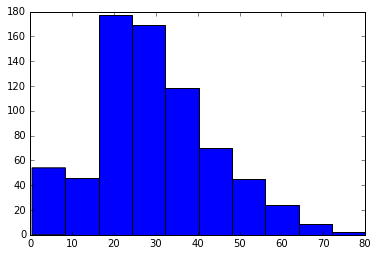

In [2]:
%matplotlib inline
#checking the shape of age distribution
age_series= titanic["Age"].dropna()

import matplotlib.pyplot as plt

plt.hist(age_series)
plt.show()


It's right-skewed. Let's fill NA with median. Later, after submiting the first solutrion to Kaggle we'll try to figure out a better way to fill those missing ages. 

In [3]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

Now let's see the shape of the age distributrion after filling missing values with the median.

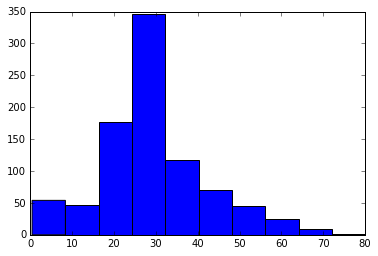

In [4]:
plt.hist(titanic["Age"])
plt.show()

I'm not quite satisfied with this workaround, but for now this is what we're going to have for the age distribution. Later on, after finishing this first iteration, we can come back and improve those missing values adopting a different strategy (for instance, fitting a linear regression model to predict and replace missing values). 

** Now, let's transform the non-numeric variables **

1) Sex

2) Embarked

In [5]:
print(titanic["Sex"].unique())

['male' 'female']


Replacing all the occurences of 'male' with the number 0 and 'female' with the number 1.

In [6]:
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

print(titanic["Sex"].value_counts(dropna=False))

0    577
1    314
Name: Sex, dtype: int64


Many more men than women boarded the ship.

In [7]:
print(titanic["Embarked"].value_counts(dropna=False))


S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64


There are just two NAs. So, we can replace them with the most common port name, which is represented by the letter 'S'.

Btw, here is the map: (C = Cherbourg; Q = Queenstown; S = Southampton)


In [9]:
titanic["Embarked"] = titanic["Embarked"].fillna("S")


Now, we replace S with 0, C with 1, and Q with 2. This is not ideal, because there's no order among the ports (for instance, 2 doesn't mean higher than 1), but for now this is enough for the first iteration in order to predict passenger survival.

If we find that the port is an important feature, we can give more attention on that "Embarked" column and maybe put more effort on translating them into better values or even spliting the dataset into categories based on the ports.

In [10]:
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

Apparently, we're done with the training data.

** So, let's prepare the testing data in a similar way **

In [11]:
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

Note that there wasn't necessary to replace missing values for the 'Fare' column in the training data. However, we found missing values in the Fare column of the testing dataset.

### Let's start fiting our predictive models

First, we'll try three classifiers: Logistic Regression, Decision Tree, and Random Forest (which is actually an ensembled method).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

#definig the predictor variables (input variables)
predictors = ["Pclass","Age","SibSp","Parch","Fare","Embarked"]

clf1 = LogisticRegression(random_state=1, C=1)
clf2 = tree.DecisionTreeClassifier(min_samples_split=50)
# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
clf3 = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=10, min_samples_leaf=5)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(clf1, titanic[predictors], titanic["Survived"], cv=kf)
print("Logistic Regression accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf2, titanic[predictors], titanic["Survived"], cv=kf)
print("Decision tree accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf3, titanic[predictors], titanic["Survived"], cv=kf)
print("Random forest accuracy score:",scores.mean())

Logistic Regression accuracy score: 0.695847362514
Decision tree accuracy score: 0.690235690236
Random forest accuracy score: 0.725028058361


Fairly good for the beginning. Let's try something to improve. 

In [14]:
# Generating a familysize column. Wandering whether or not the size of the family affect the chances to survive
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

predictors = ["Pclass","Age","SibSp","Parch","Fare","Embarked", "FamilySize"]

clf1 = LogisticRegression(random_state=1, C=1)
clf2 = tree.DecisionTreeClassifier(min_samples_split=20)
# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
clf3 = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=20, min_samples_leaf=10)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(clf1, titanic[predictors], titanic["Survived"], cv=kf)
print("Logistic Regression accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf2, titanic[predictors], titanic["Survived"], cv=kf)
print("Decision tree accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf3, titanic[predictors], titanic["Survived"], cv=kf)
print("Random forest accuracy score:",scores.mean())

Logistic Regression accuracy score: 0.695847362514
Decision tree accuracy score: 0.672278338945
Random forest accuracy score: 0.713804713805


No improvements in the quality of the model.

In [15]:
# Generating the name length column. Is there any relation between name length and chances to survive? Does it improve the model?
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [18]:
predictors = ["Pclass","Age","SibSp","Parch","Fare","Embarked","NameLength"]

clf1 = LogisticRegression(random_state=1, C=1)
clf2 = tree.DecisionTreeClassifier(min_samples_split=20)
# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
clf3 = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=20, min_samples_leaf=10)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(clf1, titanic[predictors], titanic["Survived"], cv=kf)
print("Logistic Regression accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf2, titanic[predictors], titanic["Survived"], cv=kf)
print("Decision tree accuracy score:",scores.mean())

scores = cross_validation.cross_val_score(clf3, titanic[predictors], titanic["Survived"], cv=kf)
print("Random forest accuracy score:",scores.mean())

Logistic Regression accuracy score: 0.750841750842
Decision tree accuracy score: 0.726150392817
Random forest accuracy score: 0.754208754209


We noticed a small improvement.

Let's see how SVM and Naive Bayes perform with this context.

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

clf4 = GaussianNB()
clf5 = SVC(kernel = "rbf", C=1)

scores = cross_validation.cross_val_score(clf4, titanic[predictors], titanic["Survived"], cv=kf)
print("Naive Bayes score:",scores.mean())

scores = cross_validation.cross_val_score(clf5, titanic[predictors], titanic["Survived"], cv=kf)
print("SVM accuracy score:",scores.mean())

Naive Bayes score: 0.709315375982
SVM accuracy score: 0.630751964085


No improvements. NB and SVM didn't make any improvement.

Now, we're going to fit the model for submission (using Random Forest classifier), make predictions with the test data, generate the csv output, and submit.

In [24]:
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

clf3.fit(titanic[predictors], titanic["Survived"])
predictions = clf3.predict(titanic_test[predictors])

from sklearn.metrics import accuracy_score

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kaggle.csv", index=False)

Possible next steps:
    * improve age missing values replacement
    * derivate new features (for instance, passenger title)
    * Try gradient boosting classifier. One of the most successfull classifier in kaggle competitions.